In [1]:
import matplotlib.pyplot as plt
import torch

%load_ext autoreload
%autoreload 2

In [2]:
!HF_HUB_DISABLE_PROGRESS_BARS=TRUE
!rm -rf results/pelvis/tmp
!mkdir -p results/pelvis/tmp/polypose
!mkdir -p results/pelvis/tmp/dense_xyz
!mkdir -p results/pelvis/tmp/dense_se3

## Download the dataset

In [3]:
from pathlib import Path

from huggingface_hub import snapshot_download

In [5]:
# Demonstration on the Ljubljana dataset
DATASET = "deepfluoro"
SUBJECT_ID = 1

# Download the dataset
data = f"{DATASET}/subject{SUBJECT_ID:02d}/"
download_path = snapshot_download(repo_id="eigenvivek/xvr-data", repo_type="dataset", allow_patterns=[data])
datapath = Path(download_path) / data

# Make paths to the CT and X-rays
VOLUME = datapath / "volume.nii.gz"
MASK = datapath / "mask.nii.gz"
XRAYS = datapath / "xrays"
SEGS = datapath / "segmentations"

Fetching 337 files:   0%|          | 0/337 [00:00<?, ?it/s]

## Compute the weight field

The weight of each structure $k$ at a voxel $\mathbf x$ is given by the formula:

\begin{equation}
    w_k(\mathbf x) = \frac{m_k}{1 + d^2_k(\mathbf x)} \,,
\end{equation}

where 

\begin{equation}
    d_k(\mathbf x) = \begin{cases}
        \min_{\mathbf y \in \mathbb \partial\mathbf S_k} \| \mathbf x - \mathbf y \|_2 & \mathbf x \not\in \mathbf S_k \\
        0 & \mathbf x \in \mathbf S_k
    \end{cases} \,,
\end{equation}

and $m_k$ is the relative mass of the structure, which is determined from the segmentation (i.e., we assume a constant bone density).

In [7]:
from diffdrr.data import read
from matplotlib.colors import ListedColormap

from polypose.plot import plot_weights
from polypose.weights import compute_weights

100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


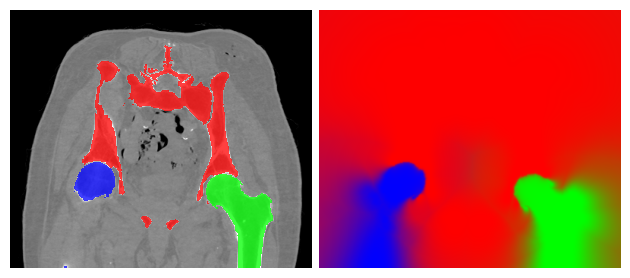

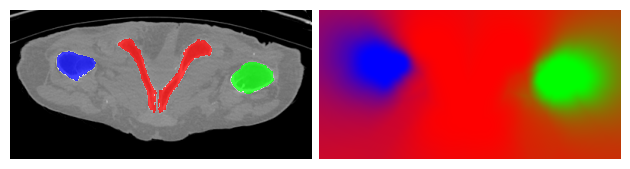

In [8]:
# Compute the segmentation and weight fields
subject = read(VOLUME, MASK)
segmentations, weights = compute_weights(subject, [[1, 2, 3, 4, 7], [5], [6]])

torch.save(segmentations, "results/pelvis/segs.pt")
torch.save(weights, "results/pelvis/weights.pt")

# Visualize slices of the weights
cmap = ListedColormap(["red"] + ["lime"] + ["blue"])
plot_weights(subject, segmentations, weights, dim=1, cmap=cmap)
plot_weights(subject, segmentations, weights, dim=2, index=60, cmap=cmap)

## Run the warp

In [9]:
from diffdrr.pose import RigidTransform
from IPython.display import Image
from torchio import LabelMap, ScalarImage
from tqdm import tqdm
from xvr.dicom import read_xray
from xvr.renderer import initialize_drr
from xvr.utils import XrayTransforms

from polypose import DenseSE3Field, DenseTranslationField, PolyPose
from polypose.loss import ImageLoss
from polypose.plot import gif, plot

In [10]:
# Imaging parameters
args = dict(
    labels=None,
    orientation="PA",
    height=1436,
    width=1436,
    sdd=1020.0,
    delx=0.194,
    dely=0.194,
    x0=0.0,
    y0=0.0,
    reverse_x_axis=True,
    renderer="trilinear",
    drr_kwargs={"voxel_shift": 0.0},
    read_kwargs={"bone_attenuation_multiplier": 2.0},
)

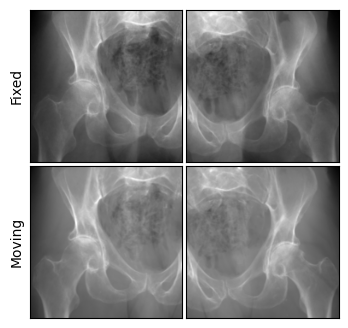

In [11]:
# Get the weights of each structure
weights = torch.load("results/pelvis/weights.pt", weights_only=True)

# Initialize the DRR
drr = initialize_drr(volume=VOLUME, mask=MASK, **args)
drr.rescale_detector_(0.125)
xt = XrayTransforms(drr.detector.height)

# Load ground truth X-ray images and camera poses
frames = [10, 9]
xrays = []
poses = []
for idx in frames:
    xray, *_ = read_xray(f"{XRAYS}/{idx:03d}.dcm", crop=100)
    pose, *_ = torch.load(f"{XRAYS}/{idx:03d}.pt")["pose"]
    xrays.append(xray)
    poses.append(pose)
gt = xt(torch.concat(xrays)).cuda()
poses = RigidTransform(torch.stack(poses)).cuda()

# Plot the images as a sanity check
img = drr(poses)
plot(gt, img)

### PolyPose

In [12]:
losses = []
imagesim = ImageLoss()
for idx, (resample, n_itrs) in enumerate(zip([4.0, 2.0, None], [51, 51, 51])):
    args["read_kwargs"] = {
        "bone_attenuation_multiplier": 2.0,
        "resample_target": resample,
    }
    drr = initialize_drr(volume=VOLUME, mask=MASK, **args)
    drr.rescale_detector_(0.125)
    xt = XrayTransforms(drr.detector.height)

    if idx == 0:
        polypose = PolyPose(drr, weights).cuda()
    else:
        polypose = PolyPose(drr, weights, polypose.poses_rot, polypose.poses_xyz).cuda()
    optimizer = torch.optim.Adam(
        [
            {"params": [polypose.poses_rot], "lr": 1e-2},
            {"params": [polypose.poses_xyz], "lr": 1e-0},
        ],
        maximize=True,
    )

    for itr in (pbar := tqdm(range(n_itrs), ncols=100)):
        img = polypose(poses)
        img = xt(img)
        loss = imagesim(gt, img)
        optimizer.zero_grad()
        loss.mean().backward()
        optimizer.step()
        if itr % 10 == 0:
            plot(
                gt,
                img,
                loss,
                savepath=f"results/pelvis/tmp/polypose/{len(losses):03d}.png",
            )
        losses.append(loss.mean().item())
        pbar.set_postfix({"loss": loss.mean().item()})

# Save snapshots of each iteration as a GIF
gif("results/pelvis/tmp/polypose", str("results/pelvis/polypose.gif"), fps=2)

100%|███████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.02it/s, loss=0.765]


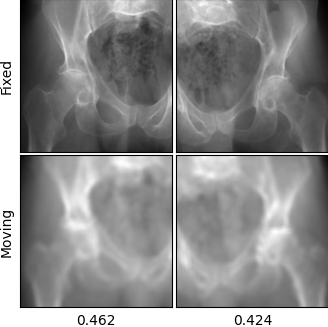

In [13]:
Image("results/pelvis/polypose.gif", width=500)

In [14]:
# Save warped volumes at the original scale
origin_volume = ScalarImage(VOLUME)
origin_mask = LabelMap(MASK)
warped_volume, warped_mask = polypose.warp_subject(affine=origin_volume.affine)

origin_volume.save("results/pelvis/original_volume.nii.gz")
origin_mask.save("results/pelvis/original_mask.nii.gz")
warped_volume.save("results/pelvis/polypose_volume.nii.gz")
warped_mask.save("results/pelvis/polypose_mask.nii.gz")

# Save the warps
torch.save(polypose, "results/pelvis/polypose.ckpt")

In [15]:
(polypose.warp.jacdet < 0).to(torch.float32).mean().item() * 100

0.0029180437195464037

### Dense Translations

In [16]:
losses = []
imagesim = ImageLoss()

args["read_kwargs"] = {"bone_attenuation_multiplier": 2.0}
drr = initialize_drr(volume=VOLUME, mask=MASK, **args)
drr.rescale_detector_(0.125)
xt = XrayTransforms(drr.detector.height)

polypose = DenseTranslationField(drr).cuda()
optimizer = torch.optim.Adam(polypose.parameters(), lr=1e-2, maximize=True)

for itr in (pbar := tqdm(range(501), ncols=100)):
    img = polypose(poses)
    img = xt(img)
    loss = imagesim(gt, img) - 1e-2 * polypose.warp.divergence.mean()
    optimizer.zero_grad()
    loss.mean().backward()
    optimizer.step()
    if itr % 10 == 0:
        plot(
            gt,
            img,
            loss,
            savepath=f"results/pelvis/tmp/dense_xyz/{len(losses):03d}.png",
        )
    losses.append(loss.mean().item())
    pbar.set_postfix({"loss": loss.mean().item()})

# Save snapshots of each iteration as a GIF
gif("results/pelvis/tmp/dense_xyz", str("results/pelvis/dense_xyz.gif"), fps=4)

100%|█████████████████████████████████████████████████| 501/501 [00:55<00:00,  9.04it/s, loss=0.976]


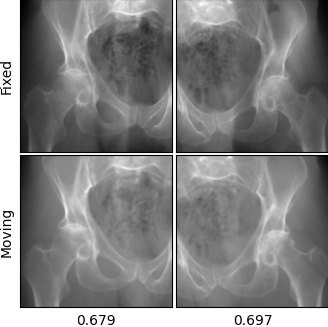

In [17]:
Image("results/pelvis/dense_xyz.gif", width=500)

In [18]:
# Save warped volumes at the original scale
origin_volume = ScalarImage(VOLUME)
origin_mask = LabelMap(MASK)
warped_volume, warped_mask = polypose.warp_subject(affine=origin_volume.affine)

warped_volume.save("results/pelvis/dense_xyz_volume.nii.gz")
warped_mask.save("results/pelvis/dense_xyz_mask.nii.gz")

# Save the warps
torch.save(polypose, "results/pelvis/dense_xyz.ckpt")

In [19]:
(polypose.warp.jacdet < 0).to(torch.float32).mean().item() * 100

0.47697541303932667

### Dense SE(3)

In [20]:
losses = []
imagesim = ImageLoss()

args["read_kwargs"] = {"bone_attenuation_multiplier": 2.0}
drr = initialize_drr(volume=VOLUME, mask=MASK, **args)
drr.rescale_detector_(0.125)
xt = XrayTransforms(drr.detector.height)

polypose = DenseSE3Field(drr).cuda()
optimizer = torch.optim.Adam(
    [
        {"params": [polypose.se3_rot], "lr": 1e-2},
        {"params": [polypose.se3_xyz], "lr": 1e-0},
    ],
    maximize=True,
)

for itr in (pbar := tqdm(range(251), ncols=100)):
    img = polypose(poses)
    img = xt(img)
    img_loss = imagesim(gt, img)
    warp_loss = polypose.warp.elastic.abs().mean()
    loss = img_loss.mean() - 1e-3 * warp_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if itr % 5 == 0:
        plot(
            gt,
            img,
            img_loss,
            savepath=f"results/pelvis/tmp/dense_se3/{len(losses):03d}.png",
        )
    losses.append(loss.mean().item())
    pbar.set_postfix(
        {
            "loss": loss.mean().item(),
            "ncc": img_loss.mean().item(),
            "elastic": warp_loss.mean().item(),
        }
    )

# Save snapshots of each iteration as a GIF
gif("results/pelvis/tmp/dense_se3", str("results/pelvis/dense_se3.gif"), fps=4)

100%|████████████████████████| 251/251 [32:32<00:00,  7.78s/it, loss=0.963, ncc=0.965, elastic=2.21]


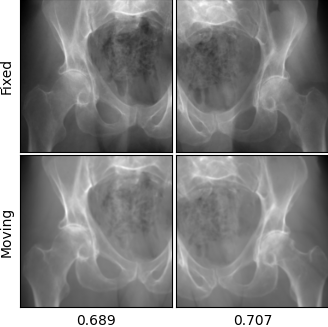

In [21]:
Image("results/pelvis/dense_se3.gif", width=500)

In [22]:
# Save warped volumes at the original scale
origin_volume = ScalarImage(VOLUME)
origin_mask = LabelMap(MASK)
warped_volume, warped_mask = polypose.warp_subject(affine=origin_volume.affine)

warped_volume.save("results/pelvis/dense_se3_volume.nii.gz")
warped_mask.save("results/pelvis/dense_se3_mask.nii.gz")

# Save the warps
torch.save(polypose, "results/pelvis/dense_se3.ckpt")

In [23]:
(polypose.warp.jacdet < 0).to(torch.float32).mean().item() * 100

45.15663385391235

## Evaluations

In [24]:
import warnings

import pandas as pd
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from torchvision.transforms import InterpolationMode
from torchvision.transforms.functional import resize

warnings.filterwarnings("ignore", category=UserWarning, module="monai.metrics")

In [25]:
imgs = []
segs = []
cams = []

idxs = []
for idx in range(37):
    if idx in frames or idx == 3:
        continue
    xray, *_ = read_xray(f"{XRAYS}/{idx:03d}.dcm", crop=100)
    pose, *_ = torch.load(f"{XRAYS}/{idx:03d}.pt", weights_only=False)["pose"]

    seg = torch.load(f"{SEGS}/{idx:03d}.pt", weights_only=False).squeeze()
    seg = seg[50:-50, 50:-50][None, None].to(torch.float32).cuda()
    seg = resize(seg, (179, 179), interpolation=InterpolationMode.NEAREST_EXACT)

    idxs.append(idx)
    imgs.append(xray.cuda())
    cams.append(RigidTransform(pose).cuda())
    segs.append(seg)

imgs = xt(torch.concat(imgs))
segs = torch.concat(segs)

In [26]:
# Compute image similarity metrics
args["labels"] = "0,1,2,3,4,5,6,7"
drr_original = initialize_drr(
    volume="results/pelvis/original_volume.nii.gz",
    mask="results/pelvis/original_mask.nii.gz",
    **args,
)
drr_polypose = initialize_drr(
    volume="results/pelvis/polypose_volume.nii.gz",
    mask="results/pelvis/polypose_mask.nii.gz",
    **args,
)
drr_densexyz = initialize_drr(
    volume="results/pelvis/dense_xyz_volume.nii.gz",
    mask="results/pelvis/dense_xyz_mask.nii.gz",
    **args,
)
drr_densese3 = initialize_drr(
    volume="results/pelvis/dense_se3_volume.nii.gz",
    mask="results/pelvis/dense_se3_mask.nii.gz",
    **args,
)
drr_original.rescale_detector_(0.125)
drr_polypose.rescale_detector_(0.125)
drr_densexyz.rescale_detector_(0.125)
drr_densese3.rescale_detector_(0.125)
xt = XrayTransforms(drr_original.detector.height)

preds_original = []
preds_polypose = []
preds_densexyz = []
preds_densese3 = []
for pose in tqdm(cams, ncols=100):
    with torch.no_grad():
        preds_original.append(drr_original(pose, mask_to_channels=True))
        preds_polypose.append(drr_polypose(pose, mask_to_channels=True))
        preds_densexyz.append(drr_densexyz(pose, mask_to_channels=True))
        preds_densese3.append(drr_densese3(pose, mask_to_channels=True))

preds_original = torch.concat(preds_original)
preds_polypose = torch.concat(preds_polypose)
preds_densexyz = torch.concat(preds_densexyz)
preds_densese3 = torch.concat(preds_densese3)

100%|███████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 39.52it/s]


In [27]:
dice = DiceMetric(reduction="none")
haus = HausdorffDistanceMetric(include_background=True, percentile=95, reduction="none")
mncc = ImageLoss()


def labels_to_channels(seg, labels=range(0, 7)):
    return torch.concat([seg == idx for idx in labels], dim=1)


def reformat(segs):
    lfemur = segs[:, [5]] > 0
    rfemur = segs[:, [6]] > 0
    pelvis = segs[:, [1, 2, 3, 4]].sum(dim=1, keepdim=True) > 0
    pelvis = ~(lfemur | rfemur) & pelvis
    return torch.concat([pelvis, lfemur, rfemur], dim=1)


def surface(pred, true):
    pred = reformat(pred)
    true = reformat(true)

    dice_metric = dice(pred, true).cpu()
    haus_metric = haus(pred, true).cpu()

    too_small = (true.sum(dim=[-1, -2]) < 500).cpu()
    dice_metric[too_small] = torch.nan
    haus_metric[too_small] = torch.nan

    return dice_metric, haus_metric

In [28]:
# Calculate mNCC
mncc_original = mncc(xt(preds_original.sum(dim=1, keepdim=True)), imgs).cpu().unsqueeze(1)
mncc_polypose = mncc(xt(preds_polypose.sum(dim=1, keepdim=True)), imgs).cpu().unsqueeze(1)
mncc_densexyz = mncc(xt(preds_densexyz.sum(dim=1, keepdim=True)), imgs).cpu().unsqueeze(1)
mncc_densese3 = mncc(xt(preds_densese3.sum(dim=1, keepdim=True)), imgs).cpu().unsqueeze(1)

# Calculate Dice and HD95
dice_original, haus_original = surface(preds_original, labels_to_channels(segs))
dice_polypose, haus_polypose = surface(preds_polypose, labels_to_channels(segs))
dice_densexyz, haus_densexyz = surface(preds_densexyz, labels_to_channels(segs))
dice_densese3, haus_densese3 = surface(preds_densese3, labels_to_channels(segs))

In [29]:
metrics = torch.concat([mncc_original, dice_original, haus_original], dim=-1)
df1 = pd.DataFrame(
    metrics,
    columns=[
        "mncc",
        "dice_pelvis",
        "dice_lfemur",
        "dice_rfemur",
        "hd95_pelvis",
        "hd95_lfemur",
        "hd95_rfemur",
    ],
)
df1["model"] = "original"

metrics = torch.concat([mncc_polypose, dice_polypose, haus_polypose], dim=-1)
df2 = pd.DataFrame(
    metrics,
    columns=[
        "mncc",
        "dice_pelvis",
        "dice_lfemur",
        "dice_rfemur",
        "hd95_pelvis",
        "hd95_lfemur",
        "hd95_rfemur",
    ],
)
df2["model"] = "polypose"

metrics = torch.concat([mncc_densexyz, dice_densexyz, haus_densexyz], dim=-1)
df3 = pd.DataFrame(
    metrics,
    columns=[
        "mncc",
        "dice_pelvis",
        "dice_lfemur",
        "dice_rfemur",
        "hd95_pelvis",
        "hd95_lfemur",
        "hd95_rfemur",
    ],
)
df3["model"] = "densexyz"

metrics = torch.concat([mncc_densese3, dice_densese3, haus_densese3], dim=-1)
df4 = pd.DataFrame(
    metrics,
    columns=[
        "mncc",
        "dice_pelvis",
        "dice_lfemur",
        "dice_rfemur",
        "hd95_pelvis",
        "hd95_lfemur",
        "hd95_rfemur",
    ],
)
df4["model"] = "densese3"

df = pd.concat([df1, df2, df3, df4])
df["model"] = pd.Categorical(
    df["model"],
    categories=["original", "polypose", "densexyz", "densese3"],
    ordered=True,
)
df.to_csv("results/pelvis/metrics.csv", index=False)
df.head()

mncc  dice_pelvis  dice_lfemur  dice_rfemur  hd95_pelvis  hd95_lfemur  \
0  0.780186     0.995149     0.974870     0.972064          1.0          1.0   
1  0.782339     0.995236     0.977741     0.970968          1.0          1.0   
2  0.711333     0.992499          NaN     0.944133          1.0          NaN   
3  0.651886     0.989305          NaN     0.915311          1.0          NaN   
4  0.705415     0.992538          NaN     0.943570          1.0          NaN   

   hd95_rfemur     model  
0     2.236068  original  
1     2.000000  original  
2     5.761311  original  
3     7.615773  original  
4     5.830952  original

In [30]:
df.groupby("model")[["mncc"]].agg(["mean", "std"])

mncc          
              mean       std
model                       
original  0.707866  0.043769
polypose  0.752324  0.031279
densexyz  0.752577  0.062414
densese3  0.547337  0.075576

In [31]:
df.groupby("model")[["dice_pelvis", "dice_lfemur", "dice_rfemur"]].agg(["mean", "std"])

dice_pelvis           dice_lfemur           dice_rfemur          
                mean       std        mean       std        mean       std
model                                                                     
original    0.992685  0.002028    0.963044  0.024099    0.935577  0.023011
polypose    0.992808  0.001448    0.984447  0.003161    0.983671  0.002564
densexyz    0.980237  0.003986    0.959271  0.013442    0.937936  0.020290
densese3    0.780046  0.047069    0.577416  0.068372    0.633338  0.043856

In [32]:
df.groupby("model")[["hd95_pelvis", "hd95_lfemur", "hd95_rfemur"]].agg(["mean", "std"])

hd95_pelvis           hd95_lfemur           hd95_rfemur          
                mean       std        mean       std        mean       std
model                                                                     
original    1.012183  0.071037    4.023791  3.081553    6.451237  4.180014
polypose    1.000000  0.000000    1.022782  0.092597    1.365387  0.423435
densexyz    4.585299  5.089364    3.748619  2.787331    6.323644  4.092716
densese3   18.472300  2.585818   48.882793  4.857563   51.515278  4.407551

In [33]:
def jacdet(filename):
    return (torch.load(filename, weights_only=False).warp.jacdet < 0).to(torch.float32).mean().item() * 100

In [34]:
# Compute mean Dice and HD95 for the femurs
df["dice"] = (df["dice_lfemur"] + df["dice_rfemur"]) / 2
df["hd95"] = (df["hd95_lfemur"] + df["hd95_rfemur"]) / 2
metrics = df.groupby("model")[["mncc", "dice", "hd95"]].agg(["mean", "std"])

metrics["negjacdet"] = [
    0.0,
    jacdet("results/pelvis/polypose.ckpt"),
    jacdet("results/pelvis/dense_xyz.ckpt"),
    jacdet("results/pelvis/dense_se3.ckpt"),
]

metrics.head()

mncc                dice                 hd95            \
              mean       std      mean       std       mean       std   
model                                                                   
original  0.707866  0.043769  0.959539  0.014404   4.716581  4.079498   
polypose  0.752324  0.031279  0.983925  0.001744   1.042068  0.082364   
densexyz  0.752577  0.062414  0.953437  0.012763   4.798906  3.936103   
densese3  0.547337  0.075576  0.586832  0.025725  48.031097  2.659693   

          negjacdet  
                     
model                
original   0.000000  
polypose   0.002918  
densexyz   0.476975  
densese3  45.156634

## Visualizations

### Maximum intensity projections

In [35]:
def slicer(volume, idx=110, ax=None):
    volume = ScalarImage(volume).data.squeeze()
    slice_ = volume[:, idx].flip(1).mT
    if ax is None:
        _, ax = plt.subplots()
    ax.imshow(slice_, cmap="gray")
    ax.set_axis_off()
    return ax


def render(volume, ax=None):
    volume = read(volume, bone_attenuation_multiplier=5).density.data.squeeze()
    slice_ = volume.sum(dim=1).flip(1).mT
    if ax is None:
        _, ax = plt.subplots()
    ax.imshow(slice_, cmap="gray")
    ax.set_axis_off()
    return ax


def mip(volume, mask, ax=None):
    volume = ScalarImage(volume).data.squeeze()
    mask = LabelMap(mask).data.squeeze()
    volume *= (mask == 1) | (mask == 2) | (mask == 3) | (mask == 4) | (mask == 5) | (mask == 6) | (mask == 7)
    mip = volume.max(1).values.flip(1).mT
    if ax is None:
        _, ax = plt.subplots()
    ax.imshow(mip, cmap="gray")
    ax.set_axis_off()
    return ax

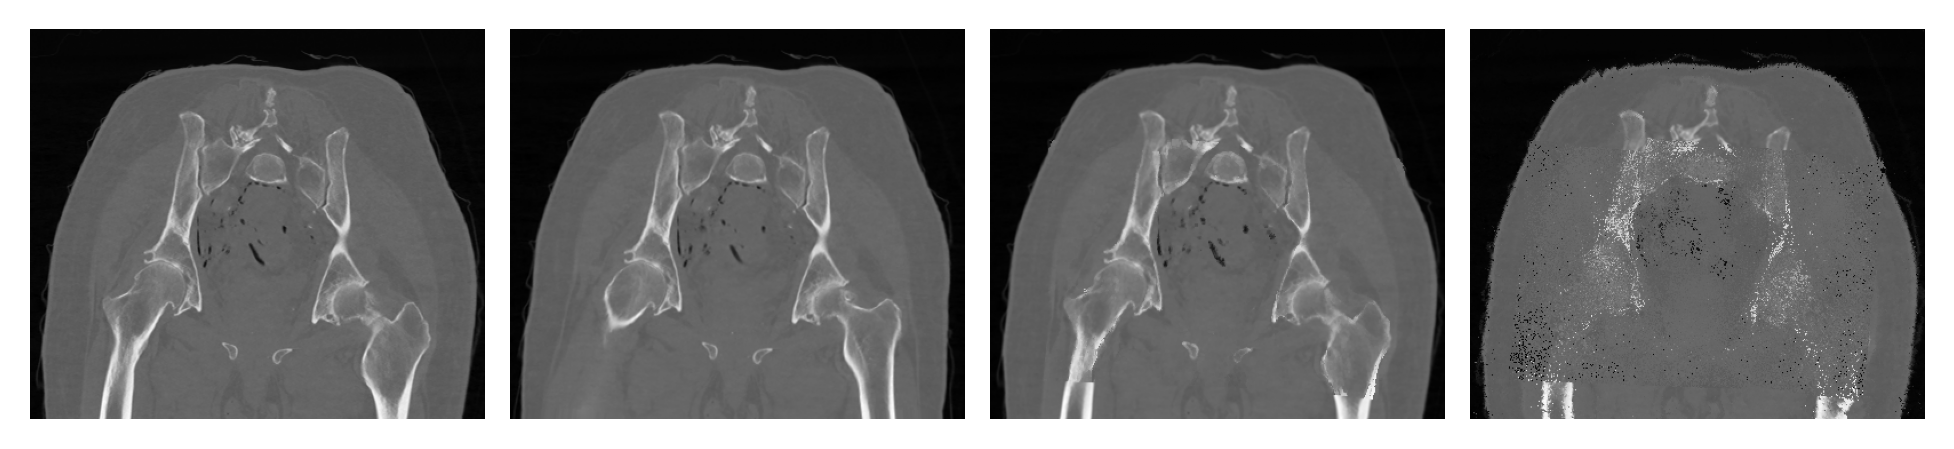

In [36]:
fig, axs = plt.subplots(ncols=4, dpi=300, constrained_layout=True)
slicer("results/pelvis/original_volume.nii.gz", ax=axs[0])
slicer("results/pelvis/polypose_volume.nii.gz", ax=axs[1])
slicer("results/pelvis/dense_xyz_volume.nii.gz", ax=axs[2])
slicer("results/pelvis/dense_se3_volume.nii.gz", ax=axs[3])
plt.show()

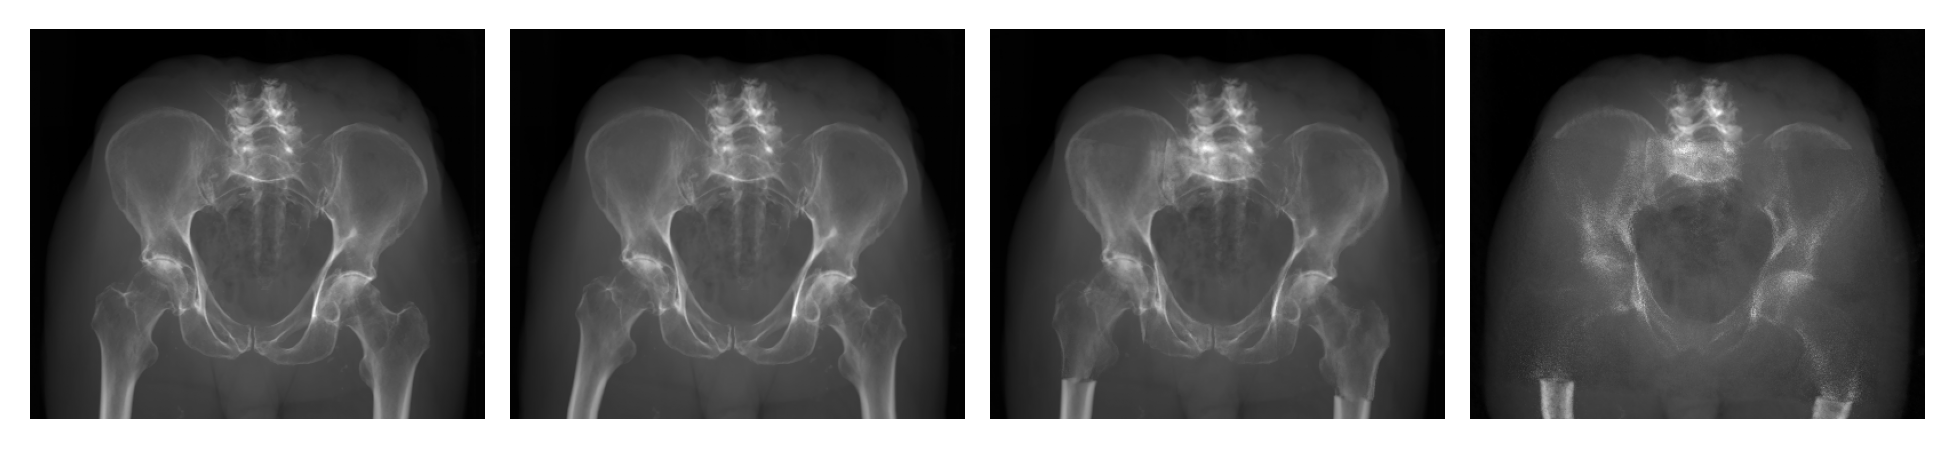

In [37]:
fig, axs = plt.subplots(ncols=4, dpi=300, constrained_layout=True)
render("results/pelvis/original_volume.nii.gz", ax=axs[0])
render("results/pelvis/polypose_volume.nii.gz", ax=axs[1])
render("results/pelvis/dense_xyz_volume.nii.gz", ax=axs[2])
render("results/pelvis/dense_se3_volume.nii.gz", ax=axs[3])
plt.show()

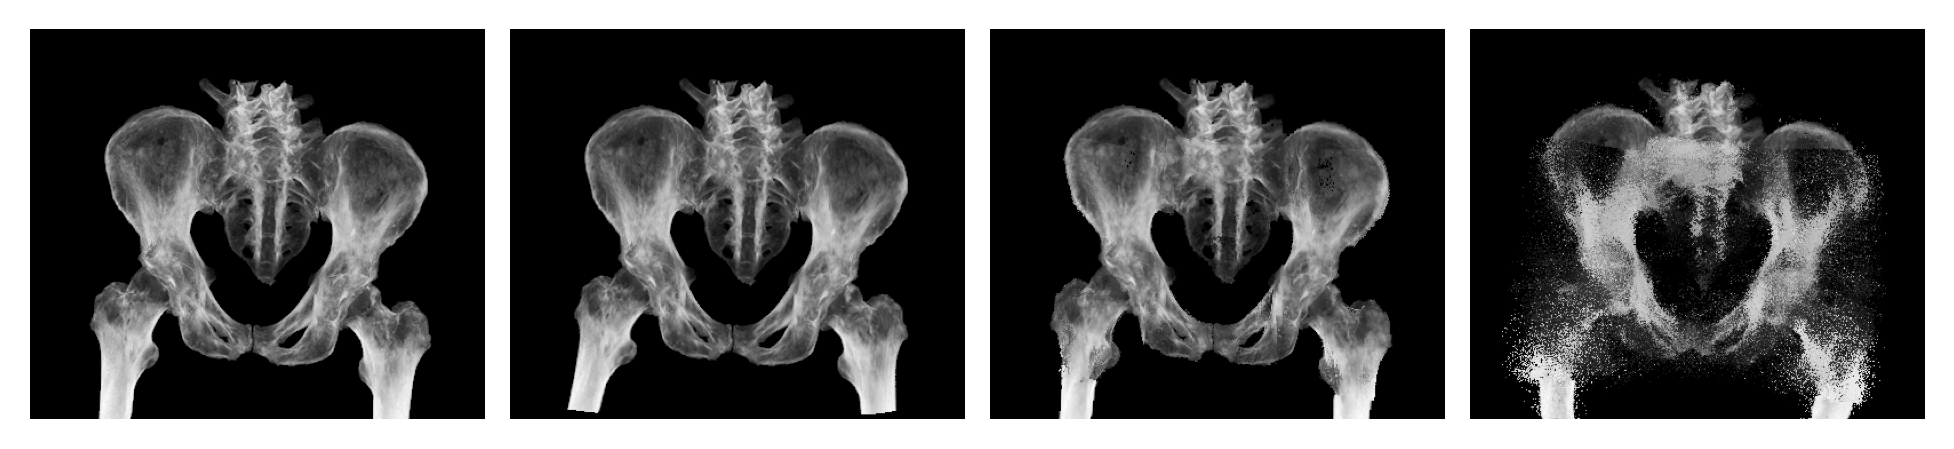

In [38]:
fig, axs = plt.subplots(ncols=4, dpi=300, constrained_layout=True)
mip(
    "results/pelvis/original_volume.nii.gz",
    "results/pelvis/original_mask.nii.gz",
    ax=axs[0],
)
mip(
    "results/pelvis/polypose_volume.nii.gz",
    "results/pelvis/polypose_mask.nii.gz",
    ax=axs[1],
)
mip(
    "results/pelvis/dense_xyz_volume.nii.gz",
    "results/pelvis/dense_xyz_mask.nii.gz",
    ax=axs[2],
)
mip(
    "results/pelvis/dense_se3_volume.nii.gz",
    "results/pelvis/dense_se3_mask.nii.gz",
    ax=axs[3],
)
plt.show()

### 3D renderings

In [37]:
import pyvista as pv
from diffdrr.visualization import labelmap_to_mesh
from IPython.display import IFrame

In [38]:
def get_mesh(volume, mask):
    args["volume"] = volume
    args["mask"] = mask

    # Segment the pelvis
    args["labels"] = "1,2,3,4,7"
    drr = initialize_drr(**args).cpu()
    pelvis = labelmap_to_mesh(drr.subject).triangulate()

    # Segment the left femur
    args["labels"] = "5"
    drr = initialize_drr(**args).cpu()
    lfemur = labelmap_to_mesh(drr.subject).triangulate()

    # Segment the right femur
    args["labels"] = "6"
    drr = initialize_drr(**args).cpu()
    rfemur = labelmap_to_mesh(drr.subject).triangulate()

    pelvis.clear_data()
    lfemur.clear_data()
    rfemur.clear_data()

    pelvis = pelvis.decimate_pro(0.5)
    lfemur = lfemur.decimate_pro(0.5)
    rfemur = rfemur.decimate_pro(0.5)

    return pelvis, lfemur, rfemur

In [39]:
def sample_deformation_field(ckpt, multiplier, cutoff):
    # Sample the deformation field
    polypose = torch.load(ckpt, weights_only=False)
    with torch.no_grad():
        idt = polypose.warp.pts.clone()[None]
        pts = polypose.warp.warp()

    # Convert back to world coordinates
    idt = polypose.warp.drr.affine(idt.reshape(-1, 1, 3)).reshape(1, polypose.warp.D, polypose.warp.H, polypose.warp.W, 3)
    pts = polypose.warp.drr.affine(pts.reshape(-1, 1, 3)).reshape(1, polypose.warp.D, polypose.warp.H, polypose.warp.W, 3)

    # Get the vectors
    centers = idt.squeeze().flatten(0, 2).cpu()
    directions = (idt - pts).squeeze().flatten(0, 2).cpu() * multiplier
    goodvecs = directions.norm(dim=-1) > cutoff

    return centers[goodvecs], directions[goodvecs]

In [40]:
def render(method, multiplier=1.0, cutoff=10.0, every=250):
    # Get the meshes and vector field
    pelvis, lfemur, rfemur = get_mesh(
        f"results/pelvis/{method}_volume.nii.gz",
        f"results/pelvis/{method}_mask.nii.gz",
    )
    centers, directions = sample_deformation_field(
        f"results/pelvis/{method}.ckpt",
        multiplier=multiplier,
        cutoff=cutoff,
    )

    # Plot the mesh
    pl = pv.Plotter()
    pl.add_mesh(pelvis, color="#e3dac9")
    pl.add_mesh(lfemur, color="#e3dac9")
    pl.add_mesh(rfemur, color="#e3dac9")

    # Plot the vector field
    pl.add_arrows(
        centers[::every].numpy(),
        directions[::every].numpy(),
        opacity=0.2,
        cmap="turbo",
        show_scalar_bar=False,
    )

    pl.camera_position = "xz"
    pl.camera.azimuth = 180
    pl.camera.elevation = -10
    pl.camera.zoom(1.7)

    pl.save_graphic(f"results/pelvis/warp_{method}.svg")
    pl.export_html(f"results/pelvis/{method}.html")
    IFrame(f"results/pelvis/{method}.html", 750, 500)

In [41]:
render("polypose")
IFrame("results/pelvis/polypose.html", 750, 500)

/data/vision/polina/users/vivekg/polypose/.venv/lib/python3.10/site-packages/pyvista/core/filters/image_data.py:961: PyVistaDeprecationWarning: This filter produces unexpected results and is deprecated. Use `contour_labels` instead.
Refer to the documentation for `contour_labeled` for details on how to transition to the new filter.
See https://github.com/pyvista/pyvista/issues/5981 for details.
  warnings.warn(
Performing Labeled Surface Extraction: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████[00:00<00:00]
Smoothing Mesh using Taubin Smoothing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████[00:01<00:00]
Cleaning: 100%|████████████████████████████████████████████████████████████████████████████████████████████

In [42]:
render("dense_xyz", multiplier=7.5, every=15)
IFrame("results/pelvis/dense_xyz.html", 750, 500)

/data/vision/polina/users/vivekg/polypose/.venv/lib/python3.10/site-packages/pyvista/core/filters/image_data.py:961: PyVistaDeprecationWarning: This filter produces unexpected results and is deprecated. Use `contour_labels` instead.
Refer to the documentation for `contour_labeled` for details on how to transition to the new filter.
See https://github.com/pyvista/pyvista/issues/5981 for details.
  warnings.warn(
Performing Labeled Surface Extraction: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████[00:00<00:00]
Smoothing Mesh using Taubin Smoothing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████[00:01<00:00]
Cleaning: 100%|████████████████████████████████████████████████████████████████████████████████████████████

In [43]:
render("dense_se3", multiplier=1.5)
IFrame("results/pelvis/dense_se3.html", 750, 500)

Performing Labeled Surface Extraction: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████[00:01<00:00]
Smoothing Mesh using Taubin Smoothing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████[00:05<00:00]
Cleaning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████[00:00<00:00]
Performing Labeled Surface Extraction: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████[00:00<00:00]
Smoothing Mesh using Taubin Smoothing: 100%|